In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import ast
import os
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
%matplotlib inline

NUM_CATS= 340
BASE_SIZE=256
size=64
imgs_per_class=2000
Train_path = 'train_simplified/'

In [3]:
category_files = os.listdir(Train_path)
print(category_files)

['airplane.csv', 'alarm clock.csv', 'ambulance.csv', 'angel.csv', 'animal migration.csv', 'ant.csv', 'anvil.csv', 'apple.csv', 'arm.csv', 'asparagus.csv', 'axe.csv', 'backpack.csv', 'banana.csv', 'bandage.csv', 'barn.csv', 'baseball bat.csv', 'baseball.csv', 'basket.csv', 'basketball.csv', 'bat.csv', 'bathtub.csv', 'beach.csv', 'bear.csv', 'beard.csv', 'bed.csv', 'bee.csv', 'belt.csv', 'bench.csv', 'bicycle.csv', 'binoculars.csv', 'bird.csv', 'birthday cake.csv', 'blackberry.csv', 'blueberry.csv', 'book.csv', 'boomerang.csv', 'bottlecap.csv', 'bowtie.csv', 'bracelet.csv', 'brain.csv', 'bread.csv', 'bridge.csv', 'broccoli.csv', 'broom.csv', 'bucket.csv', 'bulldozer.csv', 'bus.csv', 'bush.csv', 'butterfly.csv', 'cactus.csv', 'cake.csv', 'calculator.csv', 'calendar.csv', 'camel.csv', 'camera.csv', 'camouflage.csv', 'campfire.csv', 'candle.csv', 'cannon.csv', 'canoe.csv', 'car.csv', 'carrot.csv', 'castle.csv', 'cat.csv', 'ceiling fan.csv', 'cell phone.csv', 'cello.csv', 'chair.csv', 'chand

In [4]:
categories = [file.replace('.csv','') for file in category_files]
categories

['airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball bat',
 'baseball',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crown',
 'cruise ship',
 

In [5]:
from sklearn.preprocessing import LabelEncoder
word_encoder = LabelEncoder()
word_encoder.fit(categories)

LabelEncoder()

Class airplane.csv


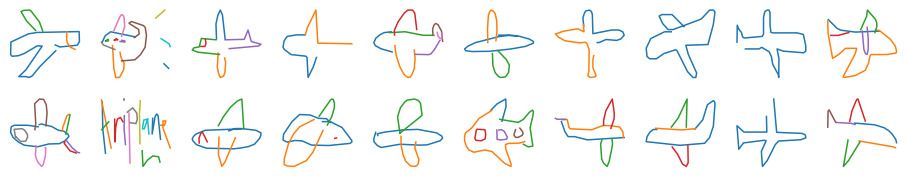

Class alarm clock.csv


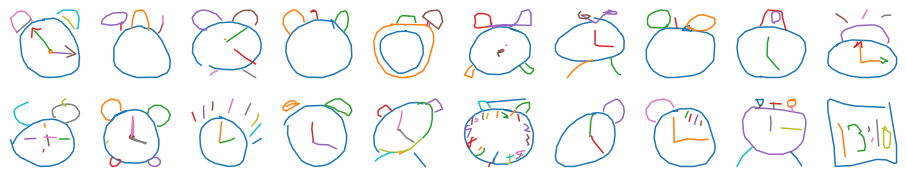

In [6]:
from PIL import Image

for i in range(2):
    print('Class',category_files[i])
    file = os.path.join(Train_path,category_files[i])
    file = pd.read_csv(file)
    file=file[:20]
    file['drawing']=file['drawing'].apply(ast.literal_eval)
    fig, axs = plt.subplots(2, 10, figsize=(16, 3))
    for j,drawing in enumerate(file.drawing):
        ax = axs[j // 10, j % 10]
        for x,y in drawing:
            #print('x: ',x)
            #print('y: ',y)
            ax.plot(x,-np.array(y));
        ax.axis('off');
        #vector = np.matrix(drawing)
        #print(vector)
        #arr2 = np.asarray(vector).reshape(arr.shape)
        
        # make a PIL image
        #img2 = Image.fromarray(arr2, 'RGBA')
        #img2.show()
    plt.show()
    #print(np.stack(file['drawing'],0))

In [7]:
count=[]
for file in category_files:
    df = pd.read_csv(os.path.join(Train_path, file))
    count.append(len(df))

In [8]:
categorised_count=[]
categorised_count.append(len([x for x in count if x<150000]))
categorised_count.append(len([x for x in count if 200000>x>150000]))
categorised_count.append(len([x for x in count if 200000<x<250000]))
categorised_count.append(len([x for x in count if 250000<x<300000]))
categorised_count.append(len([x for x in count if 300000<x]))

<BarContainer object of 5 artists>

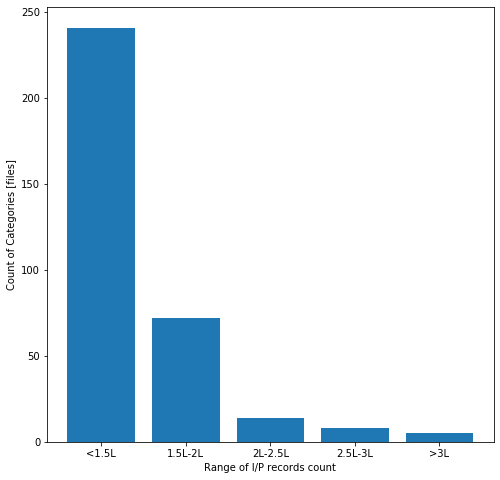

In [10]:
plt.figure(1,figsize=(8,8))
plt.xlabel('Range of I/P records count')
plt.ylabel('Count of Categories [files]')
plt.bar(['<1.5L','1.5L-2L','2L-2.5L','2.5L-3L','>3L'],categorised_count)

In [ ]:
import json
file = os.path.join(Train_path,category_files[0])
file = pd.read_csv(file)
file['drawing'] = file['drawing'].apply(json.loads)

In [ ]:
print(file.head())

In [ ]:
import cv2
def convert_df_array(raw_strokes,size=256,lw=5,time_color=True):
    image = np.zeros((BASE_SIZE,BASE_SIZE),np.uint8)
    for i,stroke in enumerate(raw_strokes):
        for j in range(len(stroke[0])-1):
            color = 255-min(i,10)*13 if time_color else 255
            cv2.line(image,(stroke[0][j],stroke[1][j]),
                     (stroke[0][j+1],stroke[1][j+1]),color,lw)
    if size != BASE_SIZE:
        return cv2.resize(image, (size, size))
    else:
        return image

In [ ]:
def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = convert_df_array(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [ ]:
def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(Train_path,category_files[k])
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = convert_df_array(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(word_encoder.transform(df.word.values), num_classes=NCATS)
                yield x, y

In [ ]:
valid_df = pd.read_csv(os.path.join(Train_path, category_files[0]), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(word_encoder.transform(valid_df.word.values), num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

In [ ]:
train_datagen = image_generator_xd(size=size, batchsize=680, ks=range(100))

In [ ]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [ ]:
%%timeit
x, y = next(train_datagen)

In [ ]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
print(model.summary())

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True,save_weights_only=True)

model.fit_generator(train_data_gen, validation_data=(x_valid, y_valid), epochs=70, callbacks=[checkpointer], 
          steps_per_epoch=800, verbose=1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(size,size,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(340, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 680)              

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

datagen_valid = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

datagen_train.fit(x_train)
datagen_valid.fit(x_valid)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpoint],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)